In [6]:
import mediapipe as mp
import cv2
import time
import os
import glob
from pathlib import Path
import pandas as pd 
from mat4py import loadmat


In [7]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/drive/MyDrive/AFLW2000-3D.zip') == True:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/drive/MyDrive/AFLW2000-3D.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
nose_coords = []
brows_coords = []
def extract_points(image):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
    min_detection_confidence=0.0,
    min_tracking_confidence=0.0) as face_mesh:
    results = face_mesh.process(image)
    Xs = []
    Ys = []
  for land_marks in results.multi_face_landmarks:
    for i,landmark in enumerate(land_marks.landmark):
      if i == 1:
        nose_coords.append(landmark.x * image.shape[1])
        nose_coords.append(landmark.y * image.shape[0])
      if i == 160:
        brows_coords.append(landmark.x * image.shape[1])
        brows_coords.append(landmark.y * image.shape[0])
        
      Xs.append(landmark.x * image.shape[1])
      Ys.append(landmark.y * image.shape[0])
  coords = Xs + Ys 
  a_series = pd.Series(coords)
  return a_series

In [11]:
df = pd.DataFrame()
for img in sorted(glob.glob("/content/AFLW2000/*.jpg")):
  image = cv2.imread(img)
  df = df.append(extract_points(image),ignore_index=True)

In [12]:
df_labels = pd.DataFrame()
for mat_file in sorted(glob.glob("/content/AFLW2000/*.mat")):
  file = loadmat(mat_file)
  a_series = pd.Series(file['Pose_Para'][:3])
  df_labels = df_labels.append(a_series,ignore_index=True)

In [13]:
df_labels.rename(columns = {0:'yaw', 1:'pitch',2:'roll'}, inplace = True)

In [14]:
nose_coords_lsts = [nose_coords[i:i + 2] for i in range(0, len(nose_coords), 2)]

In [15]:
len(brows_coords)

4000

In [16]:
brows_coords_lsts = [brows_coords[i:i + 2] for i in range(0, len(brows_coords), 2)]

In [19]:
import numpy as np
# domin = []
# nose_coords_arr = np.array(nose_coords_lsts)
# brows_coords_arr = np.array(brows_coords_lsts) 
# for i in range(nose_coords_arr.shape[0]):
#     domin.append(np.linalg.norm(nose_coords_arr[i] - brows_coords_arr[i]))


diff_between_nose_and_brows = np.array(nose_coords_lsts) - np.array(brows_coords_lsts) 
diff_df = pd.DataFrame(diff_between_nose_and_brows , columns=['Xs','Ys'])


In [21]:
# ## adding dominator list to the dataframe to ease the division process 
# df['domin'] = domin

# ## divide each row by the value from domin 
# df = df.div(df.iloc[:,-1],axis=0)

# ## Normalizing the points by subtracting the nose 
# df = df.sub(df.iloc[:,1],axis=0)

dfX = df.iloc[:,:468]
dfY = df.iloc[:,468:]

dfX['Xs'] = diff_df['Xs']
dfY['Ys'] = diff_df['Ys']

dfX = dfX.div(dfX.iloc[:,-1],axis=0)
dfY = dfY.div(dfY.iloc[:,-1],axis=0)


dfX = dfX.sub(dfX.iloc[:,1],axis=0)
dfY = dfY.sub(dfY.iloc[:,1],axis=0)

df = pd.concat([dfX,dfY],axis=1)
df.drop(['Xs','Ys'],axis=1,inplace=True)

In [22]:
## merging the tables (points and labels) to be ready for the model
DF = pd.concat([df,df_labels],axis=1)

In [23]:
## removing unnecessary columns 
DF.drop([1,'domin'],axis=1,inplace=True)

In [25]:
X = DF.drop(['yaw','pitch','roll'],axis=1)
y = DF[['yaw','pitch','roll']]

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

In [ ]:
# from sklearn.multioutput import MultiOutputRegressor

# rfr=RandomForestRegressor()
# model1 = MultiOutputRegressor(estimator=rfr,n_jobs=-1)
# model1.fit(X_train, y_train)
# display(model1.score(X_train, y_train))

In [26]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model = model.fit(X, y)

In [27]:
# pred = model.predict(X_test)

In [28]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(y_test, pred)

In [29]:
from math import cos, sin
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

  yaw = -yaw
  if tdx != None and tdy != None:
    tdx = tdx
    tdy = tdy
  else:
    height, width = img.shape[:2]
    tdx = width / 2
    tdy = height / 2

  # X-Axis pointing to right. drawn in red
  x1 = size * (cos(yaw) * cos(roll)) + tdx
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

  # Y-Axis | drawn in green
  #        v
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
  y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

  # Z-Axis (out of the screen) drawn in blue
  x3 = size * (sin(yaw)) + tdx
  y3 = size * (-cos(yaw) * sin(pitch)) + tdy

  cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

  return img

In [37]:
image = cv2.imread("/content/bcs.jpg", cv2.IMREAD_COLOR)

In [38]:
series = extract_points(image)

In [39]:
x1 = series[1]
y1 = series[469]
x2 = series[160]
y2 = series[628]

dom = np.linalg.norm(np.array([x1,y1]) - np.array([x2,y2]))
series = series / dom 
series = series - series[1]
series = series.drop(1)

In [40]:
predd = model.predict([series])

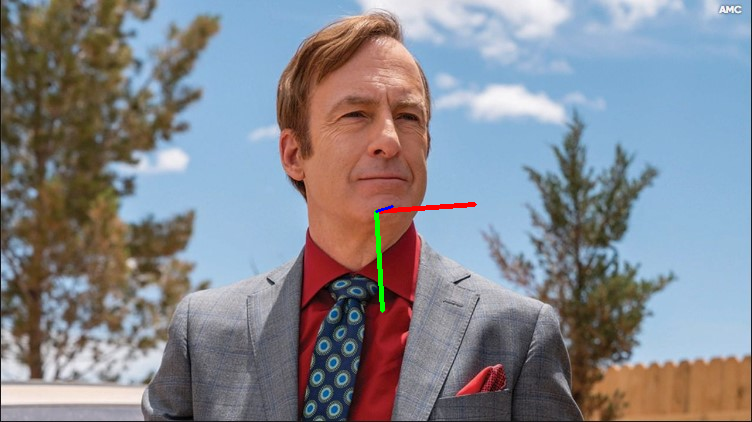

In [41]:
from google.colab.patches import cv2_imshow

cv2_imshow(draw_axis(image,predd[0][0],predd[0][1],predd[0][2]))

#DRAFT

In [42]:
# Face mesh detection
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)


In [43]:
image = cv2.imread("/content/bcs.jpg", cv2.IMREAD_COLOR)



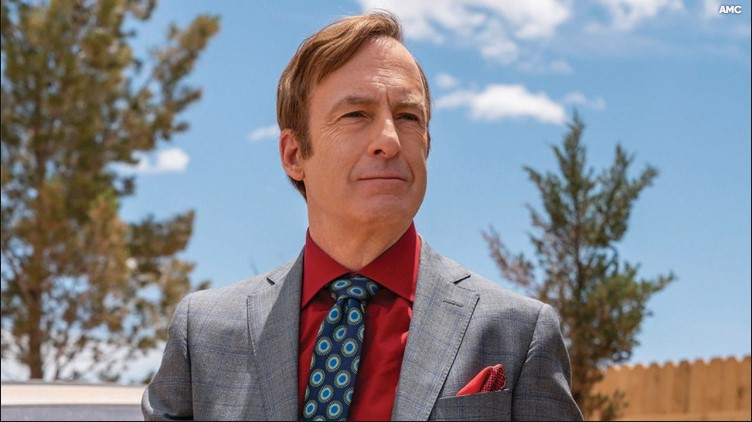

In [44]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [45]:
with mp_face_mesh.FaceMesh(
    min_detection_confidence=0.0,
    min_tracking_confidence=0.0) as face_mesh:

    results = face_mesh.process(image)

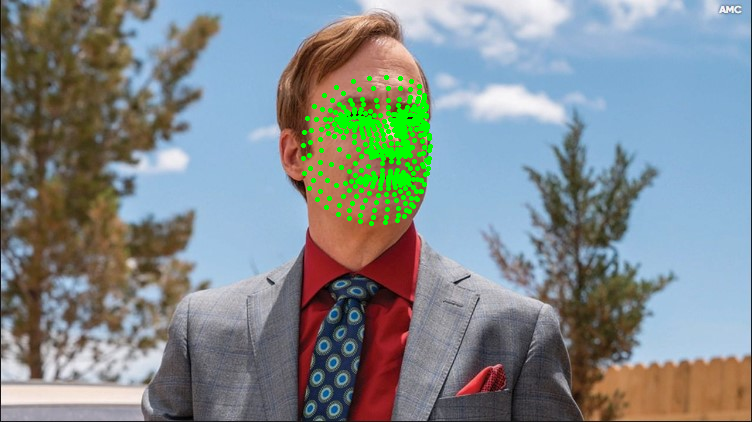

In [47]:
for face in results.multi_face_landmarks:
  for landmark in face.landmark:
    x = landmark.x
    y = landmark.y
    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
    shape = image.shape 
    relative_x = int(x * shape[1])
    relative_y = int(y * shape[0])
    # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    
cv2_imshow(image)